In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torchinfo import summary
# 加载数据
csv_file_path = 'snr_data/output_data_snr_6.csv'
data_frame = pd.read_csv(csv_file_path)

# 提取前256列数据并转换为张量
vectors = torch.tensor(data_frame.iloc[:, :256].values, dtype=torch.float32)

# 将256维向量转换为2x128的矩阵形式
vectors = vectors.view(-1, 2, 128)

# 划分训练集和测试集索引
train_size = int(0.8 * len(vectors))
test_size = len(vectors) - train_size
train_indices, test_indices = random_split(range(len(vectors)), [train_size, test_size])

# 使用训练集的统计量进行归一化
train_vectors = vectors[train_indices]

# 对IQ分量分别进行归一化
train_mean_I = train_vectors[:, 0, :].mean(dim=0, keepdim=True)
train_std_I = train_vectors[:, 0, :].std(dim=0, keepdim=True)

train_mean_Q = train_vectors[:, 1, :].mean(dim=0, keepdim=True)
train_std_Q = train_vectors[:, 1, :].std(dim=0, keepdim=True)

# 归一化整个数据集
vectors[:, 0, :] = (vectors[:, 0, :] - train_mean_I) / train_std_I
vectors[:, 1, :] = (vectors[:, 1, :] - train_mean_Q) / train_std_Q

# 提取Mod_Type列并转换为数值标签
mod_types = data_frame['Mod_Type'].astype('category').cat.codes.values
labels = torch.tensor(mod_types, dtype=torch.long)

# 创建TensorDataset
dataset = TensorDataset(vectors, labels)

# 创建训练集和测试集
train_dataset = TensorDataset(vectors[train_indices], labels[train_indices])
test_dataset = TensorDataset(vectors[test_indices], labels[test_indices])

# 创建DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [2]:
import torch
import torch.nn as nn

class CNNLSTMModel(nn.Module):
    def __init__(self):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, (2, 3), stride=1, padding=(0,1))  # Adjusted input channels and filters
        self.conv2 = nn.Conv2d(32, 32, (1, 3), stride=1, padding=(0,1))
        self.pool1 = nn.MaxPool2d((1, 2))
        self.conv3 = nn.Conv2d(32, 64, (1, 3), stride=1, padding=(0,1))
        self.conv4 = nn.Conv2d(64, 64, (1, 3), stride=1, padding=(0,1))
        self.pool2 = nn.MaxPool2d((1, 2))
        self.conv5 = nn.Conv2d(64, 128, (1, 3), stride=1, padding=(0,1))
        self.conv6 = nn.Conv2d(128, 128, (1, 3), stride=1, padding=(0,1))
        self.pool3 = nn.MaxPool2d((1, 2))

        self.lstm = nn.LSTM(128, 32, batch_first=True)  # Adjusted input size and LSTM hidden size
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 11)

    def forward(self, x):
        #print("x:",x.shape)
        if x.dim() == 3:
            x = x.unsqueeze(1)  # 假设x的形状是[2, 128], 这将改变它为[1, 2, 128]
        #print("x.unsqueeze(0):",x.shape)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool1(x)
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.pool2(x)
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = self.pool3(x)

        # Prepare input for LSTM
        x = x.view(x.size(0), 16, 128)  # Adjusted view
        #print(x.shape)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]  # Get the last output of the LSTM

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNLSTMModel().to(device)
summary(model,input_size=(1, 2, 128))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTMModel                             [1, 11]                   --
├─Conv2d: 1-1                            [1, 32, 1, 128]           224
├─Conv2d: 1-2                            [1, 32, 1, 128]           3,104
├─MaxPool2d: 1-3                         [1, 32, 1, 64]            --
├─Conv2d: 1-4                            [1, 64, 1, 64]            6,208
├─Conv2d: 1-5                            [1, 64, 1, 64]            12,352
├─MaxPool2d: 1-6                         [1, 64, 1, 32]            --
├─Conv2d: 1-7                            [1, 128, 1, 32]           24,704
├─Conv2d: 1-8                            [1, 128, 1, 32]           49,280
├─MaxPool2d: 1-9                         [1, 128, 1, 16]           --
├─LSTM: 1-10                             [1, 16, 32]               20,736
├─Linear: 1-11                           [1, 128]                  4,224
├─Linear: 1-12                           [1, 11]           

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [4]:
num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # 测试阶段
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

print("Training complete.")


Epoch [1/50], Train Loss: 1.9193, Train Accuracy: 0.2481, Test Loss: 1.6041, Test Accuracy: 0.3468
Epoch [2/50], Train Loss: 1.1881, Train Accuracy: 0.4895, Test Loss: 0.9799, Test Accuracy: 0.5705
Epoch [3/50], Train Loss: 0.8573, Train Accuracy: 0.6110, Test Loss: 0.7156, Test Accuracy: 0.6773
Epoch [4/50], Train Loss: 0.6578, Train Accuracy: 0.6866, Test Loss: 0.6639, Test Accuracy: 0.6859
Epoch [5/50], Train Loss: 0.5664, Train Accuracy: 0.7114, Test Loss: 0.5512, Test Accuracy: 0.7073
Epoch [6/50], Train Loss: 0.5070, Train Accuracy: 0.7301, Test Loss: 0.4724, Test Accuracy: 0.7355
Epoch [7/50], Train Loss: 0.4882, Train Accuracy: 0.7344, Test Loss: 0.4760, Test Accuracy: 0.7477
Epoch [8/50], Train Loss: 0.4657, Train Accuracy: 0.7385, Test Loss: 0.4976, Test Accuracy: 0.7391
Epoch [9/50], Train Loss: 0.4557, Train Accuracy: 0.7490, Test Loss: 0.4698, Test Accuracy: 0.7445
Epoch [10/50], Train Loss: 0.4379, Train Accuracy: 0.7520, Test Loss: 0.4496, Test Accuracy: 0.7441
Epoch [11

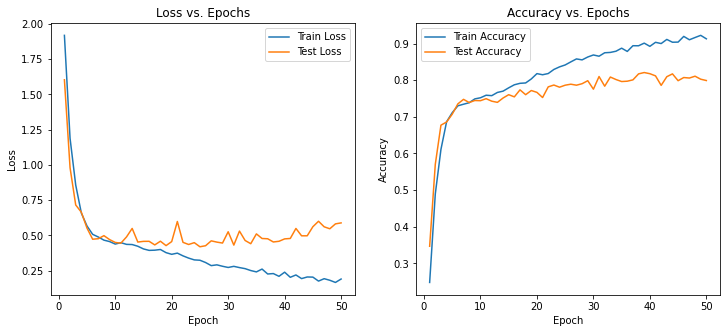

In [5]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# 绘制损失图像
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

# 绘制准确率图像
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.show()


<Figure size 720x1440 with 0 Axes>

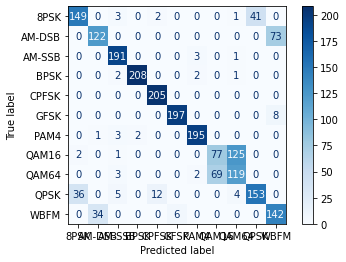

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # 确保输入数据在正确的设备上
        labels = labels.to(device)  # 确保标签也在正确的设备上
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())  # 将数据移回 CPU 并转换为 numpy
        all_predictions.extend(predicted.cpu().numpy())  # 将数据移回 CPU 并转换为 numpy

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_frame['Mod_Type'].astype('category').cat.categories)

# 设置显示尺寸并绘制混淆矩阵
plt.figure(figsize=(10, 20))  # 可以调整尺寸以适应你的需求
disp.plot(cmap=plt.cm.Blues)
plt.show()
